In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import numpy as np
import pandas as pd
import operator
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from xgboost import XGBClassifier
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

/home/joe/kaggle/mercedes/.env/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get all the orders we're training on
orders = pd.read_csv('../data/orders.csv', dtype={"order_id": np.int32, "user_id": np.int32,
                                                  "eval_set": "category", "order_number": np.int32,
                                                  "order_dow": np.int32, "order_hour_of_day": np.int32,
                                                  "days_since_prior_order": np.float32}, index_col=0)
test = orders[orders["eval_set"] == "train"].copy()
del orders

/home/joe/kaggle/mercedes/.env/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# target is "is_none", a boolean representing whether the order contains any reordered items
# count the number of reordered items for each basket:
test["size"] = pd.read_csv('../data/order_products__train.csv', dtype=np.int32, index_col=0)["reordered"].groupby(level=0).sum()
test["is_none"] = test["size"] == 0
test["dummy"] = 1  # for benchmarking

/home/joe/kaggle/mercedes/.env/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Feature Generation

## User Features

 - Number of unique items ordered previously
 - Tendency to reorder
 - Bag of products -- probably with PCA or SVD
 - Order frequency?

In [4]:
with open("user_products.pkl", "rb") as f:
    user_products = pkl.load(f)

In [5]:
users = []
bag_all_products = []
bag_last_products = []
n_unique = []
n_total = []

for user, products in user_products.items():
    if user % 10000 == 0: print(user)
    all_products = pd.Series(products.sum())
    n_unique.append(all_products.nunique())
    n_total.append(all_products.shape[0])
    bag_all_products.append(all_products)
    bag_last_products.append(pd.Series(products.iloc[-1]))
    users.append(user)

10000
20000
50000
60000
80000
90000
100000
130000
140000
150000
160000
170000
180000
190000


In [7]:
rows, cols = [], []
for i, row in enumerate(bag_all_products):
    for prod in row:
        rows.append(i)
        cols.append(prod)
data = [1]*len(rows)

bag_all_products = csr_matrix((data, (rows, cols)))
svd = TruncatedSVD(n_iter=5, n_components=10)
svd_all_products = svd_all.fit_transform(bag_all_products)
svd_all.explained_variance_.sum(),svd_all.explained_variance_ratio_
del bag_all_products

In [6]:
rows, cols = [], []
for i, row in enumerate(bag_last_products):
    for prod in row:
        rows.append(i)
        cols.append(prod)
data = [1]*len(rows)

bag_last_products = csr_matrix((data, (rows, cols)))
svd = TruncatedSVD(n_iter=5, n_components=10)
svd_last_products = svd.fit_transform(bag_last_products)
svd.explained_variance_.sum(),svd.explained_variance_ratio_
del bag_last_products

In [11]:
user_df = pd.DataFrame({
    "n_unique":n_unique,
    "n_total":n_total,
}, index=users)
user_df = pd.concat([
    user_df,
    pd.DataFrame(svd_last_products, index=users).add_prefix("svd_last_"), 
    pd.DataFrame(svd_all_products, index=users).add_prefix("svd_all_")
], axis=1)
del user_products
user_df.head()

,n_total,n_unique,svd_last_0,svd_last_1,svd_last_2,svd_last_3,svd_last_4,svd_last_5,svd_last_6,svd_last_7,...,svd_all_0,svd_all_1,svd_all_2,svd_all_3,svd_all_4,svd_all_5,svd_all_6,svd_all_7,svd_all_8,svd_all_9
1,59,18,0.055891,0.030491,-0.012940,-0.016816,-0.018459,-0.000965,0.040224,0.011704,...,1.094770,-1.238630,-2.079983,-1.837591,-0.236024,0.564903,-0.350948,1.896432,2.047514,-0.129194
2,195,102,0.860843,-0.554326,-0.380901,0.148226,-0.088994,0.779722,-0.087946,0.094471,...,8.291486,3.527698,-2.220646,3.164377,-1.844516,-0.827621,3.005491,0.622446,-0.280525,7.039742
5,37,23,0.309510,0.040743,0.192675,0.037108,0.120713,0.055769,0.047698,0.157653,...,0.868822,-0.059173,0.467416,0.014327,-0.025720,0.416526,0.172747,-0.135628,0.442846,-0.474266
7,206,68,0.421359,0.175981,-0.018990,0.862203,0.120261,-0.243970,0.065502,-0.077920,...,6.744155,-1.771422,0.395734,2.633764,3.071771,7.230325,-1.433562,-2.073179,0.362239,0.269476
8,49,36,0.223097,0.012299,0.187181,-0.057434,0.115900,0.076223,-0.024417,0.030643,...,1.405336,-0.144596,1.718967,-0.595217,-0.454596,-0.393156,-0.604084,0.765467,-0.051871,-0.780643


In [14]:
# merge into feature dataframe
test = pd.merge(test, user_df, left_on="user_id", right_index=True)

In [35]:
user_df.to_csv("user_df_train.csv")
test.to_csv("feature_df_train.csv")

In [17]:
test = pd.read_csv("feature_df_train.csv", index_col=0)

## Order Features

# Modelling

In [41]:
y = test["is_none"]

test["pred"] = 0

X = test.drop(["user_id", "eval_set", "dummy", "size", "is_none", "pred"], axis=1)
X["ratio"] = X["n_unique"] / X["n_total"]
X["ratio2"] =  X["n_total"] / X["order_number"]
X["day_chunk"] = X["order_hour_of_day"] // 8
X["weekend"] = X["order_dow"] > 4
X["weekly"] = (X["days_since_prior_order"] % 7) == 0
X["same_day"] = X["days_since_prior_order"] == 0
X["next_day"] = X["days_since_prior_order"] == 1
X["monthly"] = X["days_since_prior_order"] == 30

In [42]:
p = cross_val_predict(LogisticRegression(),
                      test[["dummy"]], y,
                      method="predict_proba")
log_loss(y, p), roc_auc_score(y, p[:, 1])

(0.24199832420102729, 0.49996124932186314)

In [47]:
def test_model(model):
    p = cross_val_predict(model,
                          X, y,
                          method="predict_proba")
    print(log_loss(y, p), roc_auc_score(y, p[:, 1]))
    model.fit(X, y)
    try:
        pd.Series(model.steps[-1][-1].coef_.flatten(), index=X.columns).plot.bar(figsize=(12,4))
    except AttributeError:
        pd.Series(model.feature_importances_, index=X.columns).plot.bar(figsize=(12,4))     
    plt.show()
    return p

In [51]:
p1 = test_model(make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression()))
#p2 = test_model(XGBClassifier(n_estimators=128, learning_rate=0.1, max_depth=5))

0.198450322719 0.824475150562


ValueError: Wrong number of items passed 630, placement implies 34

In [49]:
p = (p1+p2)/2
print(log_loss(y, p), roc_auc_score(y, p[:, 1]))

0.19349992907 0.82945733347


In [50]:
test["pred"] = p[:,1]
test[["pred", "n_total", "n_unique", "svd_last_0", "svd_all_0",
      "days_since_prior_order", "order_dow", "order_hour_of_day",
      "size"]].sort_values("pred")

,pred,n_total,n_unique,svd_last_0,svd_all_0,days_since_prior_order,order_dow,order_hour_of_day,size
order_id,,,,,,,,,
81061,0.000158,1070,175,1.074598e+00,29.564623,12.0,0,10,35
1842218,0.000163,759,159,9.844395e-01,32.823036,21.0,0,10,23
1959513,0.000175,1170,385,1.323510e+00,33.752954,14.0,0,8,31
3344903,0.000184,792,148,1.608212e+00,51.410443,8.0,0,19,26
2624548,0.000188,1396,168,1.704876e+00,70.945828,8.0,0,20,24
1316807,0.000202,738,124,1.391446e+00,33.578796,5.0,2,21,20
974530,0.000208,1259,235,1.090089e+00,48.955050,5.0,6,11,10
1145183,0.000222,588,112,1.013514e+00,22.318339,7.0,0,8,21
2459410,0.000226,258,61,1.556646e+00,13.405083,8.0,0,16,32


In [29]:
test = test.drop("pred", axis=1)

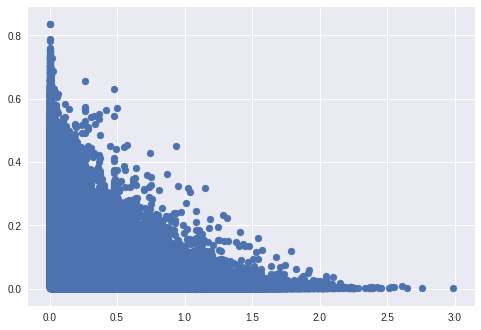

In [40]:
plt.scatter(test["svd_last_0"], test["pred"])

In [52]:
test["pred"].to_csv("none_preds_train.csv")